### Importing the standard libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

### Download datasets and Transform images
- Extract — Get the Fashion-MNIST image data from the source.
- Transform — Put our data into a tensor form.
- Load — Put our data into an object to make it easily accessible.

In [2]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) #transforms to be used for datasets 

In [3]:
# acquiring the fashionmnist datasets
dataset = torchvision.datasets.FashionMNIST(
    root = "./data", 
    train = True, 
    download = False,
    transform=transform) #if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
testset = torchvision.datasets.FashionMNIST(
    root = "./data", 
    train = False, 
    download = False,
    transform=transform)#if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
## Don't touch the test data 

split_ratio=0.8 #80-20 train/validation split 
length_train=int(split_ratio*len(dataset)) #number of training samples 
length_valid=len(dataset)-length_train #number of validation samples 

trainset, valset = torch.utils.data.random_split(dataset, [length_train, length_valid])

In [4]:
# dataloaders
#shuffle enabled as True for the train dataloader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                        shuffle=True)
# 
#shuffle enabled as False for the valid dataloader
val_loader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=False) 

#shuffle enabled as False for the test dataloader
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                        shuffle=False) 

#inspecting the length of datasets (test and train datasets)
num_train_samples=len(trainset)
print(num_train_samples)
num_test_samples=len(testset)
print(num_test_samples)
num_val_samples=len(valset)
print(num_val_samples)

48000
10000
12000


### Network architecture

In [5]:
num_pixels = 28*28

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(num_pixels, 100)
        self.dropout = nn.Dropout(p=0.3)
        self.output = nn.Linear(100, 10)

    def forward(self, x):
        x=x.squeeze(1)# removing the 1 in input batch (resizing from (batch_size,1,28,28) to (batch_size,28,28))
        x=x.view(-1,num_pixels) #resizing from (batch_size,28*28) to (batch_size,784)
        x = F.relu(self.hidden(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

### Loss function and optimizer definition

In [6]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=4e-4)

Epoch: 01, Train Loss: 0.9181, Val Loss:0.5939 Val Accuracy: 79.258%
Epoch: 02, Train Loss: 0.5942, Val Loss:0.5127 Val Accuracy: 81.567%
Epoch: 03, Train Loss: 0.5315, Val Loss:0.4734 Val Accuracy: 82.908%
Epoch: 04, Train Loss: 0.4940, Val Loss:0.4495 Val Accuracy: 84.158%
Epoch: 05, Train Loss: 0.4709, Val Loss:0.4294 Val Accuracy: 84.933%
Epoch: 06, Train Loss: 0.4519, Val Loss:0.4166 Val Accuracy: 85.108%
Epoch: 07, Train Loss: 0.4381, Val Loss:0.4079 Val Accuracy: 85.458%
Epoch: 08, Train Loss: 0.4232, Val Loss:0.3959 Val Accuracy: 85.942%
Epoch: 09, Train Loss: 0.4126, Val Loss:0.3897 Val Accuracy: 86.033%
Epoch: 10, Train Loss: 0.4047, Val Loss:0.3801 Val Accuracy: 86.633%
Epoch: 11, Train Loss: 0.3965, Val Loss:0.3761 Val Accuracy: 86.575%
Epoch: 12, Train Loss: 0.3918, Val Loss:0.3708 Val Accuracy: 86.708%
Epoch: 13, Train Loss: 0.3833, Val Loss:0.3664 Val Accuracy: 86.933%
Epoch: 14, Train Loss: 0.3764, Val Loss:0.3625 Val Accuracy: 86.850%
Epoch: 15, Train Loss: 0.3714, Val

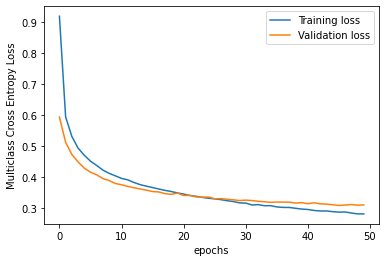

In [7]:
num_epochs = 50

# for plots
test_loss_list = []
accuracy_list = []
train_loss_list = []

count = 0
for epoch in range(num_epochs):
    train_loss = 0
    for images, labels in train_loader: 
        count += 1
        
        model.train()

        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        train = images.view(-1, num_pixels)

        # Forward pass 
        outputs = model(train)
        loss = loss_func(outputs, labels)

        # back-prop
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        train_loss += loss.item() 

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    # Run Validation for each epoch
    with torch.no_grad():
        total = 0
        correct = 0
        test_loss = 0
        for images, labels in val_loader:
            model.eval()
            images, labels = images.to(device), labels.to(device)
            test = images.view(-1, num_pixels)
            outputs = model(test).cpu()
            test_loss += loss_func(outputs, labels)

            predictions = torch.max(outputs, 1)[1]
            correct += (predictions == labels).sum().numpy()
            total += len(labels)
          
        accuracy = correct * 100 / total
        test_loss /= len(val_loader)
        test_loss_list.append(test_loss)
        accuracy_list.append(accuracy)
    
        print(f'Epoch: {epoch+1:02d}, Train Loss: {train_loss:.4f}, Val Loss:{test_loss:.4f} Val Accuracy: {accuracy:.3f}%')      

print('Finished Training')

plt.figure()
plt.plot(np.arange(num_epochs), train_loss_list, label='Training loss')
plt.plot(np.arange(num_epochs), test_loss_list, label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.legend()
plt.show()

### Test the Trained Network
Finally, we test our best model on previously unseen test data

In [8]:
# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        test = test.view(-1,num_pixels)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        labels_list.append(labels)
        predictions_list.append(predicted)
        c = (predicted == labels).squeeze()
        
        for i in range(len(predicted)):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

    print('\nOverall Test Accuracy: %2d%%'%(100. * np.sum(class_correct)/np.sum(total_correct)))    
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))


Overall Test Accuracy: 88%
Accuracy of T-shirt/Top: 84.20%
Accuracy of Trouser: 96.90%
Accuracy of Pullover: 81.40%
Accuracy of Dress: 87.60%
Accuracy of Coat: 81.20%
Accuracy of Sandal: 94.50%
Accuracy of Shirt: 68.10%
Accuracy of Sneaker: 95.80%
Accuracy of Bag: 96.50%
Accuracy of Ankle Boot: 95.70%


In [9]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

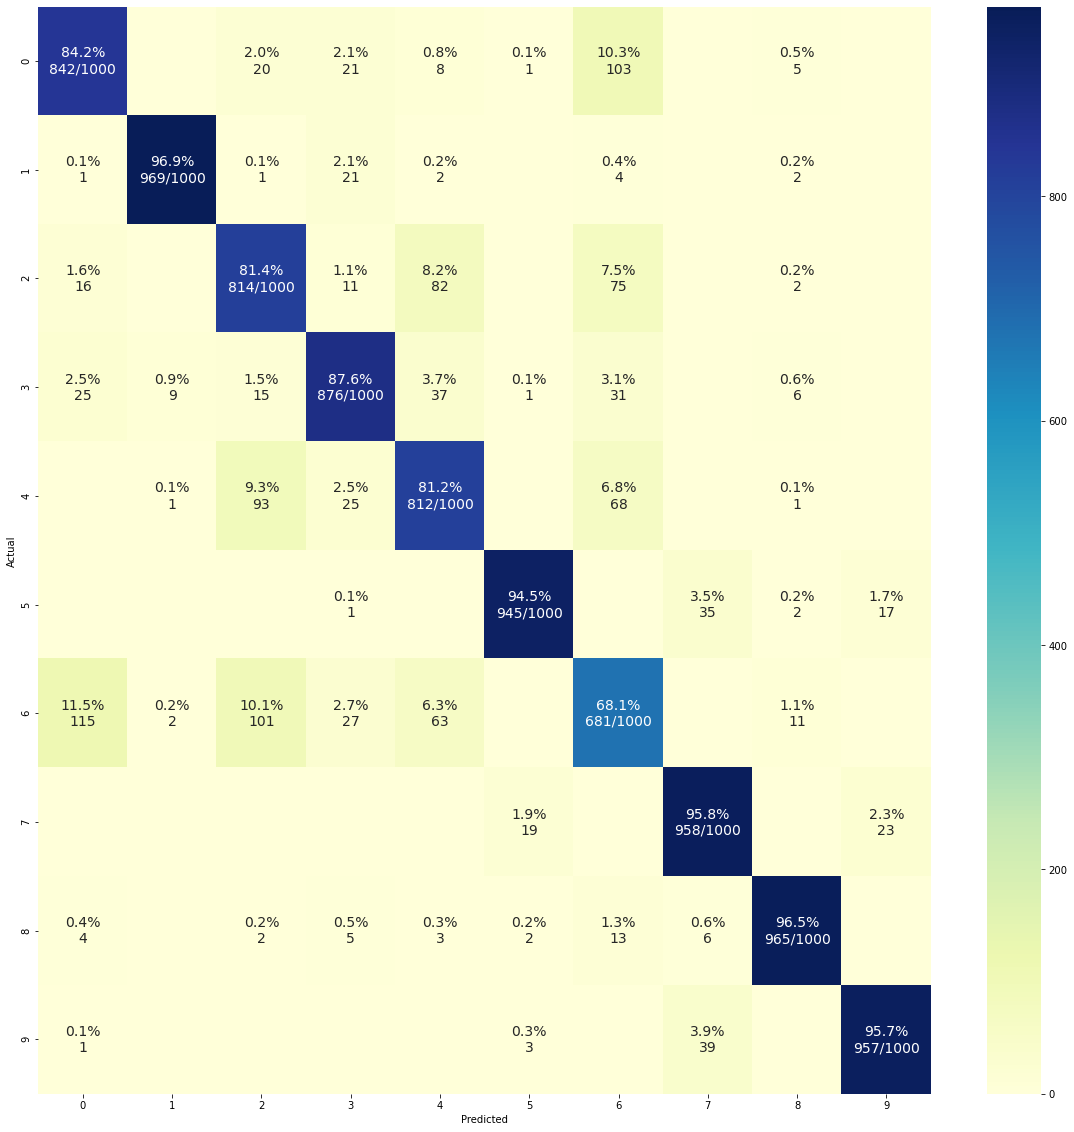

In [10]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(20,20)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"size": 14})
    
plot_cm(labels_l, predictions_l)

## Analysis
From the confusion matrix we can say that for a class m, the class that it is most likely confused for (or misclassified as) :

| (m) Class          | Most likely to be confused as |
|-----------------|-------------------------------|
| 0 (T-shirt/Top) | 6 (Shirt)                     |
| 1 (Trouser)     | 3 (Dress)                     |
| 2 (Pullover)    | 4 (Coat)                      |
| 3 (Dress)       | 4 (Coat)                      |
| 4 (Coat)        | 2 (Pullover)                  |
| 5 (Sandal)      | 7 (Sneaker)                   |
| 6 (Shirt)       | 0 (T-shirt/Top)               |
| 7 (Sneaker)     | 9 (Ankle Boot)                |
| 8 (Bag)         | 6 (Shirt)                     |
| 9 (Ankle Boot)  | 7 (Sneaker)                   |


### We can see that class - 6 (Shirt) and class - 0 (T-shirt/Top) are most likely to be confused for each other.